# Time series sentiment forecasting

### Import required Python libraries

In [1]:
import pandas as pd
import numpy as np  
import warnings
warnings.filterwarnings('ignore')

import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.arima.model import ARIMA
# Ljung-Box test for model goodness
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import statsmodels.graphics.tsaplots as sgt 

In [2]:
dd=pd.read_csv('data_sentiment.csv')

In [3]:
dd.head(10)

overall  verified  reviewTime        asin  \
0        5      True  10-20-2015  1590653289   
1        5      True  03-16-2015  1590653289   
2        5      True  12-27-2014  1590653289   
3        5      True  12-17-2014  1590653289   
4        3      True  03-14-2017  1590653289   
5        5      True  04-05-2018  193362275X   
6        4      True  03-20-2018  193362275X   
7        4      True  02-18-2018  193362275X   
8        5      True  01-08-2018  193362275X   
9        5      True  11-28-2017  193362275X   

                                                text  \
0                                        best stars    
1   great product job happy thank happy great pro...   
2   graphic designer uses pms communicate vendors...   
3   graphic designers note don t download pantone...   
4   ok ok love fact choose colors finally feel li...   
5   light flexible adaptable use easter vigil stars    
6    love little light advertised works great stars    
7    works fine little bulky like lights good light    
8                                 magnificent stars    
9   book light sad admit offers levels brightness...   

   sentiment_score_(compound) sentiment  rating                  main_cat  \
0                      0.6369  Positive       2  Tools & Home Improvement   
1                      0.9590  Positive       2  Tools & Home Improvement   
2                      0.7351  Positive       2  Tools & Home Improvement   
3                     -0.2831  Negative       0  Tools & Home Improvement   
4                      0.9880  Positive       2  Tools & Home Improvement   
5                      0.2263  Positive       2           Office Products   
6                      0.8519  Positive       2           Office Products   
7                      0.7115  Positive       2           Office Products   
8                      0.5994  Positive       2           Office Products   
9                      0.9287  Positive       2           Office Products   

             brand                                           category  \
0        Pantone    ['Tools & Home Improvement', 'Paint, Wall Trea...   
1        Pantone    ['Tools & Home Improvement', 'Paint, Wall Trea...   
2        Pantone    ['Tools & Home Improvement', 'Paint, Wall Trea...   
3        Pantone    ['Tools & Home Improvement', 'Paint, Wall Trea...   
4        Pantone    ['Tools & Home Improvement', 'Paint, Wall Trea...   
5  Mighty Bright    ['Tools & Home Improvement', 'Lighting & Ceili...   
6  Mighty Bright    ['Tools & Home Improvement', 'Lighting & Ceili...   
7  Mighty Bright    ['Tools & Home Improvement', 'Lighting & Ceili...   
8  Mighty Bright    ['Tools & Home Improvement', 'Lighting & Ceili...   
9  Mighty Bright    ['Tools & Home Improvement', 'Lighting & Ceili...   

                                               title  
0  PANTONE GP1501 Plus Series Formula Guide Coate...  
1  PANTONE GP1501 Plus Series Formula Guide Coate...  
2  PANTONE GP1501 Plus Series Formula Guide Coate...  
3  PANTONE GP1501 Plus Series Formula Guide Coate...  
4  PANTONE GP1501 Plus Series Formula Guide Coate...  
5     Mighty Bright 40516 XtraFlex2 Book Light  Pink  
6     Mighty Bright 40516 XtraFlex2 Book Light  Pink  
7     Mighty Bright 40516 XtraFlex2 Book Light  Pink  
8     Mighty Bright 40516 XtraFlex2 Book Light  Pink  
9     Mighty Bright 40516 XtraFlex2 Book Light  Pink

### Load the dataset

In [4]:
df1=pd.read_csv('data_sentiment.csv', parse_dates=['reviewTime'])

### Check the structure of data

In [5]:
df1.columns

Index(['overall', 'verified', 'reviewTime', 'asin', 'text',
       'sentiment_score_(compound)', 'sentiment', 'rating', 'main_cat',
       'brand', 'category', 'title'],
      dtype='object')

In [8]:
f_data=pd.DataFrame()

In [9]:
# Finding therr score of each review using SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
sid = SentimentIntensityAnalyzer()
f_data['sentiments']           = df1['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)

In [10]:
f_data['date']=df1['reviewTime']

In [11]:
f_data = f_data.sort_values(by='date')

### Decomposing the Data to Visualize the Different Components of the Data

In [63]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
fig = make_subplots(rows=4, cols=3, subplot_titles=('Observed Positive','Observed Neutral' ,'Observed Negative', 'Trend Positive','Trend Neutral','Trend Negative','Seasonal Positive','Seasonal Neutral','Seasonal Negative','Residual Positive','Residual Neutral','Residual Negative'))
date_mean = f_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Neutral','Negative']

for idx,column in enumerate(['Positive Sentiment','Neutral Sentiment','Negative Sentiment']):
    res = seasonal_decompose(date_mean[column], period=365, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

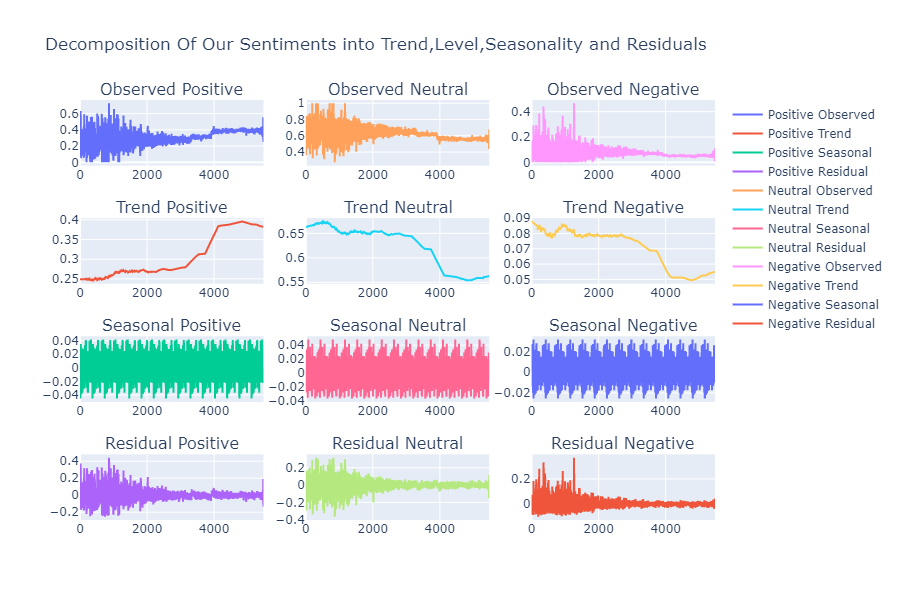

In [18]:
date_mean.set_index("date", inplace=True)
date_mean = date_mean.resample('M').mean()
positive_rating=date_mean[['Positive Sentiment']]
neutral_rating=date_mean[['Neutral Sentiment']]
negative_rating=date_mean[['Negative Sentiment']]

### Stationarity check

In [15]:
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller
# ADF test to determine data stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    

    if pvalue < 0.05:
        msg = "pvalue={}. Data is Stationary. Proceed to model building".format(pvalue)
    else:
        msg = "pvalue={}. Data is not Stationary. Make the data stationary before model building".format(pvalue)

    return msg


In [16]:
# function call
print(checkStationarity(positive_rating))
print('-'*50)
print(checkStationarity(neutral_rating))
print('-'*50)
print(checkStationarity(negative_rating))


pvalue=0.8601883147635789. Data is not Stationary. Make the data stationary before model building
--------------------------------------------------
pvalue=0.7887196610288135. Data is not Stationary. Make the data stationary before model building
--------------------------------------------------
pvalue=0.835198230690662. Data is not Stationary. Make the data stationary before model building


In [422]:
# difference the data by 1 (default)
diff_data_positive_rating = positive_rating - positive_rating.shift()
print(diff_data_positive_rating)
diff_data_positive_rating.dropna(inplace=True)
print(checkStationarity(diff_data_positive_rating))

            Positive Sentiment
date                          
1999-11-30                 NaN
1999-12-31           -0.025375
2000-01-31            0.259375
2000-02-29           -0.251000
2000-03-31           -0.004567
2000-04-30            0.039900
2000-05-31            0.027333
2000-06-30           -0.052517
2000-07-31            0.030517
2000-08-31           -0.005212
2000-09-30            0.003212
2000-10-31           -0.022242
2000-11-30            0.014076
2000-12-31           -0.009389
2001-01-31            0.016504
2001-02-28           -0.016615
2001-03-31           -0.007944
2001-04-30            0.034230
2001-05-31            0.014764
2001-06-30           -0.027633
2001-07-31            0.007345
2001-08-31           -0.052362
2001-09-30            0.075600
2001-10-31           -0.048729
2001-11-30           -0.028688
2001-12-31            0.043536
2002-01-31            0.002150
2002-02-28           -0.005987
2002-03-31           -0.003657
2002-04-30           -0.040425
2002-05-

In [423]:
# difference the data by 1 (default)
diff_data_neutral_rating = neutral_rating - neutral_rating.shift()
print(diff_data_neutral_rating)
diff_data_neutral_rating.dropna(inplace=True)
print(checkStationarity(diff_data_neutral_rating))

            Neutral Sentiment
date                         
1999-11-30                NaN
1999-12-31          -0.019500
2000-01-31          -0.330500
2000-02-29           0.315500
2000-03-31          -0.042733
2000-04-30           0.031733
2000-05-31          -0.052141
2000-06-30           0.028066
2000-07-31          -0.005213
2000-08-31          -0.036802
2000-09-30           0.019498
2000-10-31           0.040320
2000-11-30          -0.025672
2000-12-31           0.010444
2001-01-31          -0.001859
2001-02-28           0.023192
2001-03-31          -0.017944
2001-04-30          -0.070103
2001-05-31           0.075564
2001-06-30           0.013483
2001-07-31          -0.021619
2001-08-31           0.047352
2001-09-30          -0.077879
2001-10-31           0.031083
2001-11-30           0.086146
2001-12-31          -0.120869
2002-01-31           0.000683
2002-02-28           0.042333
2002-03-31          -0.080627
2002-04-30           0.097962
2002-05-31          -0.010067
2002-06-30

In [424]:
# difference the data by 1 (default)
diff_data_negative_rating = negative_rating - negative_rating.shift()
print(diff_data_negative_rating)
diff_data_negative_rating.dropna(inplace=True)
print(checkStationarity(diff_data_negative_rating))

            Negative Sentiment
date                          
1999-11-30                 NaN
1999-12-31            0.044875
2000-01-31            0.070625
2000-02-29           -0.064000
2000-03-31            0.047100
2000-04-30           -0.071433
2000-05-31            0.024590
2000-06-30            0.024652
2000-07-31           -0.025171
2000-08-31            0.041763
2000-09-30           -0.022481
2000-10-31           -0.018185
2000-11-30            0.011667
2000-12-31           -0.001111
2001-01-31           -0.014722
2001-02-28           -0.006556
2001-03-31            0.026000
2001-04-30            0.035746
2001-05-31           -0.090107
2001-06-30            0.013583
2001-07-31            0.014881
2001-08-31            0.005219
2001-09-30            0.001879
2001-10-31            0.017604
2001-11-30           -0.057417
2001-12-31            0.077286
2002-01-31           -0.002632
2002-02-28           -0.036397
2002-03-31            0.084244
2002-04-30           -0.057500
2002-05-

# Double Exponent Smoothing (trend, but no seasonality)

### Time series Sentiment forecasting of the Amazon home category

In [21]:
f_data1=f_data.copy()
f_data['date']=df1['reviewTime']
f_data1[['main_cat','brand', 'category', 'title']]=df1[['main_cat','brand', 'category', 'title']]

In [22]:
amazon_home=f_data1[f_data1['main_cat']=='Amazon Home']

In [23]:
amazon_home=amazon_home[['Positive Sentiment','Neutral Sentiment','Negative Sentiment','date']]
#sorting date wise
amazon_home = amazon_home.sort_values(by='date')
#setting date as index
amazon_home.set_index("date", inplace=True)
#month wise
amazon_home = amazon_home.resample('M').mean()

# seprating sentiment wise
amazon_home_positive_rating=amazon_home[['Positive Sentiment']]
amazon_home_neutral_rating=amazon_home[['Neutral Sentiment']]
amazon_home_negative_rating=amazon_home[['Negative Sentiment']]

In [24]:
amazon_home_positive_rating.isnull().sum()
amazon_home_neutral_rating.isnull().sum()
amazon_home_negative_rating.isnull().sum()

mean1=amazon_home_positive_rating['Positive Sentiment'].mean()
mean2=amazon_home_neutral_rating['Neutral Sentiment'].mean()
mean3=amazon_home_negative_rating['Negative Sentiment'].mean()

amazon_home_positive_rating.fillna(value=mean1,inplace=True)
amazon_home_neutral_rating.fillna(value=mean2,inplace=True)
amazon_home_negative_rating.fillna(value=mean3,inplace=True)

amazon_home_positive_rating.drop(index='2018-10-31',inplace=True)
amazon_home_neutral_rating.drop(index='2018-10-31',inplace=True)
amazon_home_negative_rating.drop(index='2018-10-31',inplace=True)

### Time series Sentiment forecasting  for positive sentiment

In [25]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(amazon_home_positive_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues
forecast = model2.forecast(steps=24)
# calculate MAE
mae = mean_absolute_error(amazon_home_positive_rating, fcst2)
print("MAE: ", mae)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(amazon_home_positive_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.03175871881200424
RMSE:  0.054098468806273725


In [26]:
pl=amazon_home_positive_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Positive Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Positive Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=0, traceorder="normal",xanchor='right', yanchor='bottom'))
fig3.show()

##### Conclusion:Graph of Time series Sentiment forecasting for positive sentiment shows that there is drop in sentiment. 

### Time series Sentiment forecasting  for neutral sentiment

In [28]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(amazon_home_neutral_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues

forecast = model2.forecast(steps=24)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate MAE
mae = mean_absolute_error(amazon_home_neutral_rating, fcst2)
print("MAE: ", mae)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(amazon_home_neutral_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.031204763289400802
RMSE:  0.05625760503406856


In [29]:
pl=amazon_home_neutral_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Neutral Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Neutral Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=1, traceorder="normal",xanchor='right', yanchor='top'))
fig3.show()

##### Conclusion:Graph of Time series Sentiment forecasting for neutral sentiment shows that there is slight rise in sentiment for the next two years. 

### Time series Sentiment forecasting  for negative sentiment

In [30]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(amazon_home_negative_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues
forecast = model2.forecast(steps=24)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate MAE
mae = mean_absolute_error(amazon_home_negative_rating, fcst2)
print("MAE: ", mae)

# calculate RMSEmse = np.sqrt(mean_squared_error(amazon_home_negative_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.01930588953637783
RMSE:  0.05625760503406856


In [31]:
pl=amazon_home_negative_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Negative Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Negative Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=1, traceorder="normal",xanchor='right', yanchor='top'))
fig3.show()

###### Conclusion:Graph of Time series Sentiment forecasting for negative sentiment shows that there is rise in sentiment from october 2018 

# Tools & Home Improvement Time Sentiment forecasting

In [32]:
tool=f_data1[f_data1['main_cat']=='Tools & Home Improvement']

In [33]:
tool=tool[['Positive Sentiment','Neutral Sentiment','Negative Sentiment','date']]
#sorting date wise
tool = tool.sort_values(by='date')
#setting date as index
tool.set_index("date", inplace=True)
#month wise
tool = tool.resample('M').mean()

# seprating sentiment wise
tool_positive_rating=tool[['Positive Sentiment']]
tool_neutral_rating=tool[['Neutral Sentiment']]
tool_negative_rating=tool[['Negative Sentiment']]

In [34]:
tool_positive_rating.drop(index='2018-10-31',inplace=True)
tool_neutral_rating.drop(index='2018-10-31',inplace=True)
tool_negative_rating.drop(index='2018-10-31',inplace=True)

### Time series Sentiment forecasting  for positve sentiment

In [35]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(tool_positive_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues
forecast = model2.forecast(steps=24)
# calculate MAE
mae = mean_absolute_error(tool_positive_rating, fcst2)
print("MAE: ", mae)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(tool_positive_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.016355399821019318
RMSE:  0.03142738246538106


In [36]:
pl=tool_positive_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Positive Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Positive Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=1, traceorder="normal",xanchor='right', yanchor='top'))
fig3.show()

##### Conclusion:Graph of Time series Sentiment forecasting for positive sentiment shows that there is drop in sentiment. 

### Time series Sentiment forecasting  for neutral sentiment

In [37]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(tool_neutral_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues

forecast = model2.forecast(steps=24)
# calculate MAE
mae = mean_absolute_error(tool_neutral_rating, fcst2)
print("MAE: ", mae)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(tool_neutral_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.016543215349300745
RMSE:  0.03701003343852011


In [38]:
pl=tool_neutral_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Neutral Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Neutral Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=1, traceorder="normal",xanchor='right', yanchor='top'))
fig3.show()

##### Conclusion:Graph of Time series Sentiment forecasting for neutral sentiment shows that there is slight drop in sentiment for the next two years. 

### Time series Sentiment forecasting  for negative sentiment

In [39]:
from statsmodels.tsa.api import SimpleExpSmoothing,ExponentialSmoothing
# Double Exponent - (Holts' method) 
# parameters: alpha, beta
alpha = 0.8
beta = 0.2
model2 = ExponentialSmoothing(tool_negative_rating,trend='additive').fit(smoothing_level=alpha, smoothing_slope=beta)

# forecast with double exponent smoothing
fcst2 = model2.fittedvalues
forecast = model2.forecast(steps=24)
# calculate MAE
mae = mean_absolute_error(tool_negative_rating, fcst2)
print("MAE: ", mae)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(tool_negative_rating, fcst2))
print("RMSE: ", rmse)

MAE:  0.009807079376800988
RMSE:  0.017895592658304052


In [40]:
pl=tool_negative_rating.reset_index()
pl['fitvalue']=model2.fittedvalues.values

forecast = model2.forecast(steps=24).reset_index()

import plotly.express as px
fig3 = px.line(pl, y='Negative Sentiment', x='date')

fig3.add_scatter(x=pl['date'], y=pl['Negative Sentiment'],name='Actual values')
fig3.add_scatter(x=pl['date'], y=pl['fitvalue'],name='Predicted values')
fig3.add_scatter(x=forecast['index'], y=forecast[0],name='Forecast values')
fig3.update_layout(legend=dict(x=1, y=1, traceorder="normal",xanchor='right', yanchor='top'))
fig3.show()

###### Conclusion:Graph of Time series Sentiment forecasting for negative sentiment shows that there is rise in sentiment from october 2018 

# Time series forecasting using Fbprophet

In [58]:
!pip install prophet

  Using cached holidays-0.18-py3-none-any.whl (195 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)


In [41]:
amazon_fb=pd.read_csv('amazon.csv')
amazon_fb1=pd.read_csv('amazon.csv')
amazon_fb2=pd.read_csv('amazon.csv')

######## 
amazon_fb['date'] = pd.to_datetime(amazon_fb['date'])
amazon_fb.set_index('date', inplace=True)

amazon_fb1['date'] = pd.to_datetime(amazon_fb1['date'])
amazon_fb1.set_index('date', inplace=True)

amazon_fb2['date'] = pd.to_datetime(amazon_fb2['date'])
amazon_fb2.set_index('date', inplace=True)

#######
amazon_fb=amazon_fb.resample('M').mean()
amazon_fb.drop(index='2018-10-31',inplace=True)

amazon_fb1=amazon_fb1.resample('M').mean()
amazon_fb1.drop(index='2018-10-31',inplace=True)

amazon_fb2=amazon_fb2.resample('M').mean()
amazon_fb2.drop(index='2018-10-31',inplace=True)

#######
mean=amazon_fb['Positive Sentiment'].mean()
amazon_fb.fillna(value=mean,inplace=True)

mean1=amazon_fb1['Neutral Sentiment'].mean()
amazon_fb1.fillna(value=mean1,inplace=True)

mean2=amazon_fb2['Negative Sentiment'].mean()
amazon_fb2.fillna(value=mean2,inplace=True)

#####
amazon_fb.reset_index(inplace=True)
amazon_fb1.reset_index(inplace=True)
amazon_fb2.reset_index(inplace=True)

In [ ]:
# Positive Sentiment

In [42]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
amazon_fb = amazon_fb.rename(columns={'date': 'ds', 'Positive Sentiment': 'y'})

# Instantiate a Prophet model
model = Prophet()

# Fit the model on the time series data
model.fit(amazon_fb)

# Create a DataFrame to hold future predictions
future_data = model.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast = model.predict(future_data)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast['ds'][223:], y=forecast['yhat'][223:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=amazon_fb['ds'], y=amazon_fb['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Positive Sentiment')

# Show the plot
fig.show()


11:31:24 - cmdstanpy - INFO - Chain [1] start processing
11:31:25 - cmdstanpy - INFO - Chain [1] done processing


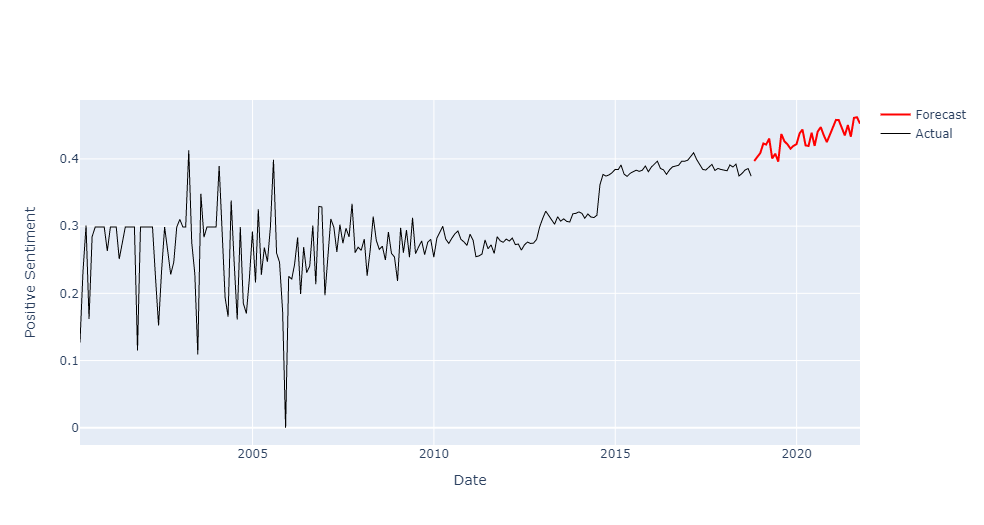

In [46]:
import numpy as np

# Split data into train and test sets
train_data = amazon_fb.iloc[:156]
test_data = amazon_fb.iloc[156:]
# Instantiate a Prophet model
model = Prophet()
# Fit the model on the train data
model.fit(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['yhat']]

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Mean Squared Error:", mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Root Mean Squared Error:", rmse)

11:31:31 - cmdstanpy - INFO - Chain [1] start processing
11:31:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.00823034596051826
Root Mean Squared Error: 0.0907212541828995


In [47]:
# Neutral Sentiment

In [48]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
amazon_fb1 = amazon_fb1.rename(columns={'date': 'ds', 'Neutral Sentiment': 'y'})

# Instantiate a Prophet model
model1 = Prophet()

# Fit the model on the time series data
model1.fit(amazon_fb1)

# Create a DataFrame to hold future predictions
future_data1 = model1.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast1 = model1.predict(future_data1)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast1['ds'][223:], y=forecast1['yhat'][223:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=amazon_fb1['ds'], y=amazon_fb1['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Netural Sentiment')

# Show the plot
fig.show()


11:31:32 - cmdstanpy - INFO - Chain [1] start processing
11:31:32 - cmdstanpy - INFO - Chain [1] done processing


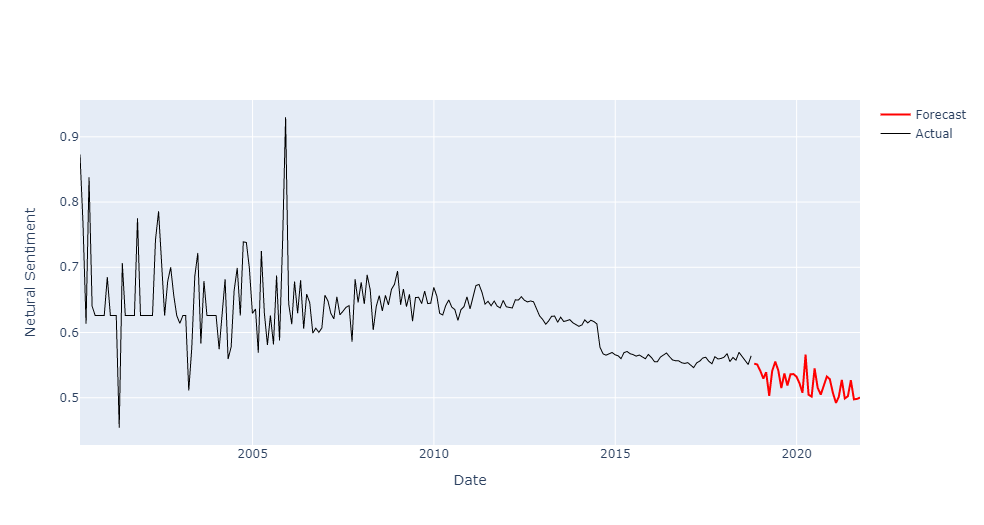

In [49]:
import numpy as np

# Split data into train and test sets
train_data = amazon_fb1.iloc[:156]
test_data = amazon_fb1.iloc[156:]
# Instantiate a Prophet model
model = Prophet()
# Fit the model on the train data
model.fit(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['yhat']]

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Mean Squared Error:", mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Root Mean Squared Error:", rmse)

11:31:33 - cmdstanpy - INFO - Chain [1] start processing
11:31:33 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.0047807246442372634
Root Mean Squared Error: 0.06914278446980034


In [50]:
# negative Sentiment

In [51]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
amazon_fb2 = amazon_fb2.rename(columns={'date': 'ds', 'Negative Sentiment': 'y'})

# Instantiate a Prophet model
model2 = Prophet()

# Fit the model on the time series data
model2.fit(amazon_fb2)

# Create a DataFrame to hold future predictions
future_data2 = model2.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast2 = model2.predict(future_data2)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast2['ds'][223:], y=forecast2['yhat'][223:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=amazon_fb2['ds'], y=amazon_fb2['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Negative Sentiment')

# Show the plot
fig.show()


11:31:34 - cmdstanpy - INFO - Chain [1] start processing
11:31:34 - cmdstanpy - INFO - Chain [1] done processing


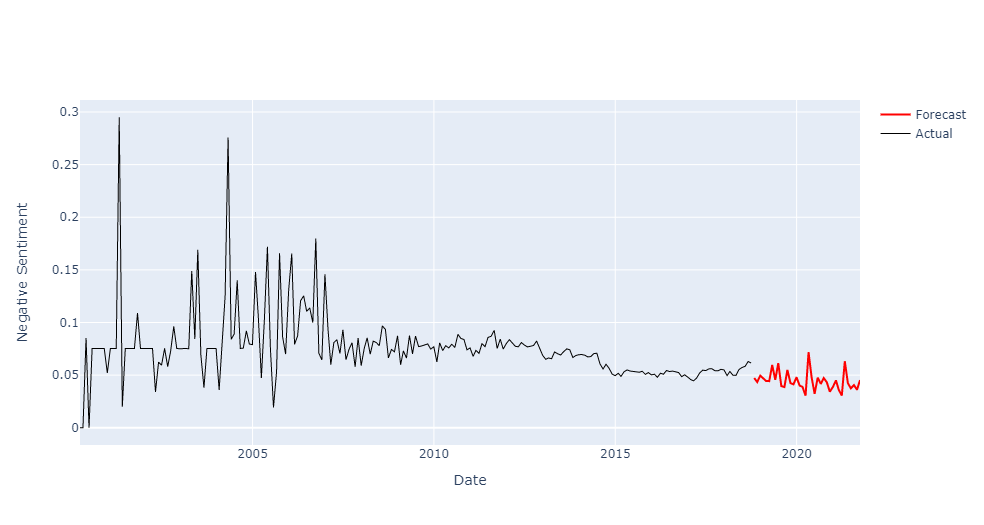

In [52]:
import numpy as np

# Split data into train and test sets
train_data = amazon_fb2.iloc[:156]
test_data = amazon_fb2.iloc[156:]
# Instantiate a Prophet model
model = Prophet()
# Fit the model on the train data
model.fit(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['yhat']]

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Mean Squared Error:", mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Root Mean Squared Error:", rmse)

11:31:36 - cmdstanpy - INFO - Chain [1] start processing
11:31:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.0004170696342663477
Root Mean Squared Error: 0.020422282787836126


# Tools & Home improvement category

In [53]:
tool_fb=pd.read_csv('tool.csv')
tool_fb1=pd.read_csv('tool.csv')
tool_fb2=pd.read_csv('tool.csv')

########
tool_fb['date'] = pd.to_datetime(tool_fb['date'])
tool_fb.set_index('date', inplace=True)

tool_fb1['date'] = pd.to_datetime(tool_fb1['date'])
tool_fb1.set_index('date', inplace=True)

tool_fb2['date'] = pd.to_datetime(tool_fb2['date'])
tool_fb2.set_index('date', inplace=True)


############
tool_fb=tool_fb.resample('M').mean()
tool_fb.drop(index='2018-10-31',inplace=True)

tool_fb1=tool_fb1.resample('M').mean()
tool_fb1.drop(index='2018-10-31',inplace=True)

tool_fb2=tool_fb2.resample('M').mean()
tool_fb2.drop(index='2018-10-31',inplace=True)

#########
tool_fb.reset_index(inplace=True)
tool_fb1.reset_index(inplace=True)
tool_fb2.reset_index(inplace=True)

In [54]:
#Positive Sentiment

In [55]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
tool_fb = tool_fb.rename(columns={'date': 'ds', 'Positive Sentiment': 'y'})

# Instantiate a Prophet model
model = Prophet()

# Fit the model on the time series data
model.fit(tool_fb)

# Create a DataFrame to hold future predictions
future_data = model.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast = model.predict(future_data)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast['ds'][227:], y=forecast['yhat'][227:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=tool_fb['ds'], y=tool_fb['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Positive Sentiment')

# Show the plot
fig.show()


11:31:44 - cmdstanpy - INFO - Chain [1] start processing
11:31:44 - cmdstanpy - INFO - Chain [1] done processing


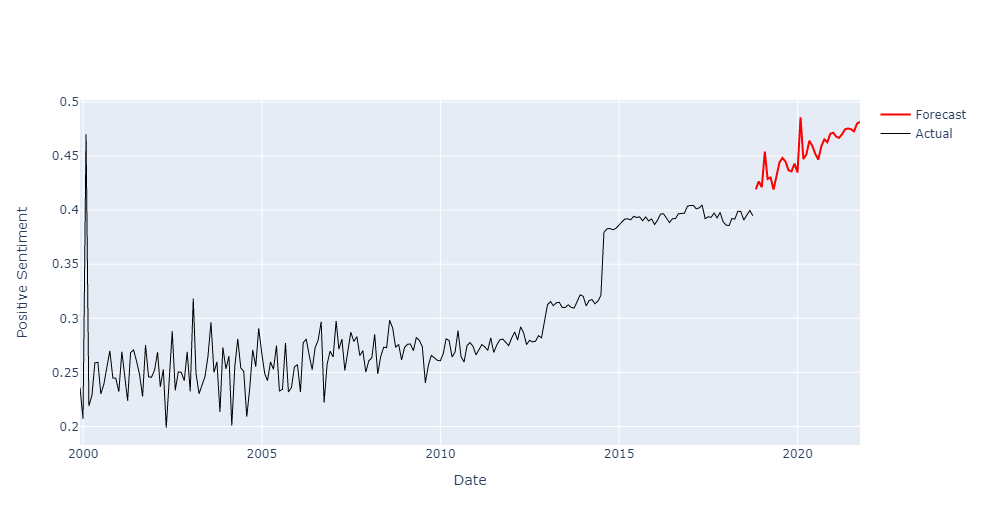

In [56]:
import numpy as np

# Split data into train and test sets
train_data = tool_fb.iloc[:156]
test_data = tool_fb.iloc[156:]
# Instantiate a Prophet model
model = Prophet()
# Fit the model on the train data
model.fit(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['yhat']]

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Mean Squared Error:", mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Root Mean Squared Error:", rmse)

11:31:45 - cmdstanpy - INFO - Chain [1] start processing
11:31:45 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.007866586609951046
Root Mean Squared Error: 0.08869377999584326


In [57]:
# Neutral Sentiment

In [58]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
tool_fb1 = tool_fb1.rename(columns={'date': 'ds', 'Neutral Sentiment': 'y'})

# Instantiate a Prophet model
model1 = Prophet()

# Fit the model on the time series data
model1.fit(tool_fb1)

# Create a DataFrame to hold future predictions
future_data1 = model1.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast1 = model1.predict(future_data1)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast1['ds'][227:], y=forecast1['yhat'][227:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=tool_fb1['ds'], y=tool_fb1['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Neutral Sentiment')

# Show the plot
fig.show()


11:31:46 - cmdstanpy - INFO - Chain [1] start processing
11:31:46 - cmdstanpy - INFO - Chain [1] done processing


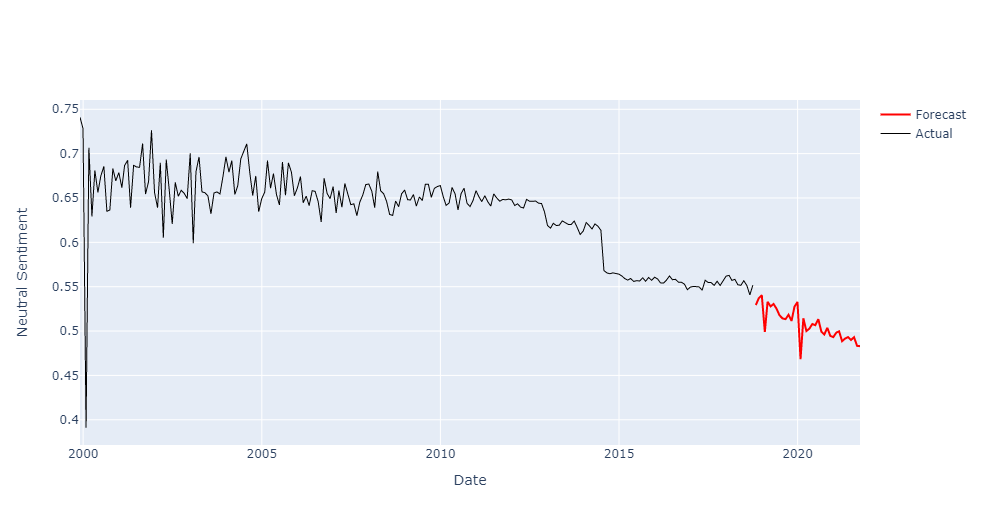

In [59]:
import numpy as np

# Split data into train and test sets
train_data = tool_fb1.iloc[:156]
test_data = tool_fb1.iloc[156:]
# Instantiate a Prophet model
model = Prophet()
# Fit the model on the train data
model.fit(train_data)

# Make predictions on the test set
test_predictions = model.predict(test_data[['ds']])
test_predictions = test_predictions[['yhat']]

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Mean Squared Error:", mean_squared_error(test_data['y'], test_predictions['yhat']))
print("Root Mean Squared Error:", rmse)

11:31:52 - cmdstanpy - INFO - Chain [1] start processing
11:31:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 0.004874463125266511
Root Mean Squared Error: 0.06981735547316663


In [60]:
#Negative Sentiment

In [61]:
from prophet import Prophet


# Rename the columns to match the format expected by Prophet
tool_fb2 = tool_fb2.rename(columns={'date': 'ds', 'Negative Sentiment': 'y'})

# Instantiate a Prophet model
model2 = Prophet()

# Fit the model on the time series data
model2.fit(tool_fb2)

# Create a DataFrame to hold future predictions
future_data2 = model2.make_future_dataframe(periods=36, freq='M')

# Make predictions
forecast2 = model2.predict(future_data2)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a subplot with one row and one column
fig = sp.make_subplots(rows=1, cols=1)

# Define the trace for the forecast results
trace_forecast = go.Scatter(x=forecast2['ds'][227:], y=forecast2['yhat'][227:], mode='lines', name='Forecast',line=dict(color='red', width=2))

# Define the trace for the actual results
trace_actual = go.Scatter(x=tool_fb2['ds'], y=tool_fb2['y'], mode='lines', name='Actual',line=dict(color='black', width=1))

# Add the trace to the subplot
fig.add_trace(trace_forecast)
fig.add_trace(trace_actual)

# Update the layout of the plot to add axis labels
fig.update_layout(xaxis_title='Date', yaxis_title='Negative Sentiment')

# Show the plot
fig.show()


11:31:53 - cmdstanpy - INFO - Chain [1] start processing
11:31:53 - cmdstanpy - INFO - Chain [1] done processing


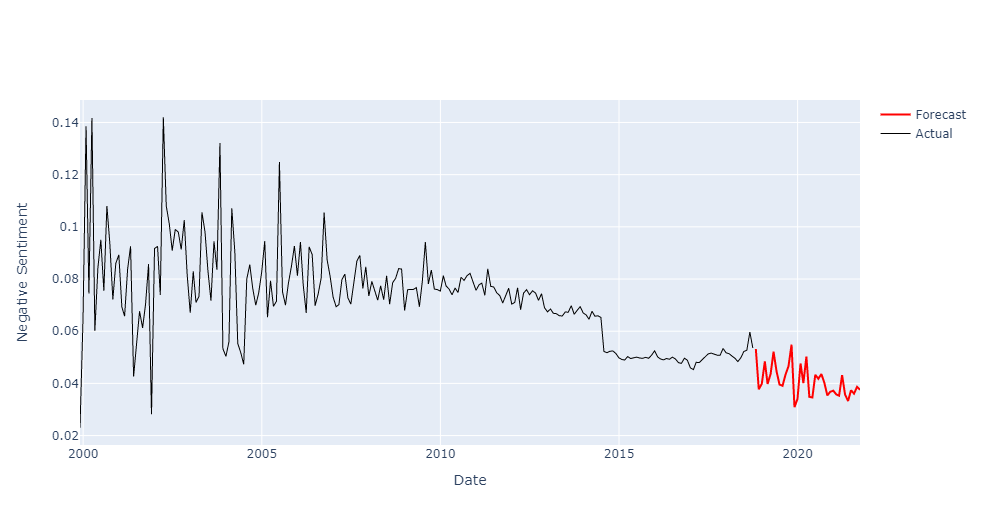